In [6]:
! pip install datasets -q

## Env cnflicts

In [2]:
# !pip install --upgrade --force-reinstall torchvision torchaudio torchtext --index-url https://download.pytorch.org/whl/cu118/

In [3]:
# !pip install --force-reinstall sentence-transformers

In [6]:
# !pip install wandb

In [3]:
from sentence_transformers import SentenceTransformer

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
os.chdir("/content/drive/MyDrive/Genetative AI with Large Language Models")
os.getcwd()

'/content/drive/MyDrive/Genetative AI with Large Language Models'

## **Generating Contrastive Examples**

When pretraining your embedding model, **you will often see data being
used from natural language inference (NLI) datasets**. NLI refers to the task
of investigating whether, for a given premise, it entails the hypothesis
(entailment), contradicts it (contradiction), or neither (neutral).

**For example**, when the premise is “He is in the cinema watching Coco” and
the hypothesis “He is watching Frozen at home,” then these statements are
contradictions.

In contrast, when the premise is “He is in the cinema watching Coco” and the hypothesis “In the movie theater he is watching the Disney movie Coco,” then these statements are considered entailment.


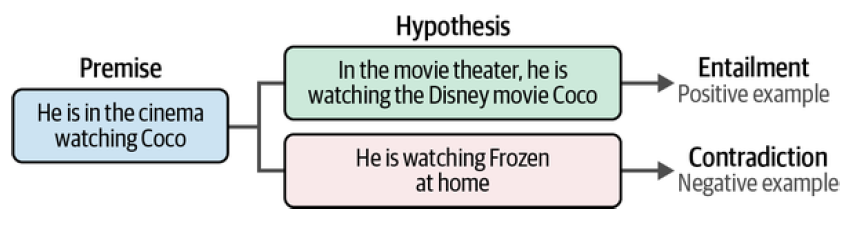


**Entailment (समर्थन), Contradiction (विरोध), Neutral (तटस्थ)**


| Premise                                | Hypothesis                              | Label          |
|----------------------------------------|----------------------------------------|----------------|
| सूर्य पूर्वेकडून उगवतो.               | सूर्य कधीच पश्चिमेकडून उगवत नाही.    | Contradiction  |
| राम ने नवीन मोबाईल खरेदी केला.        | रामकडे आता एक नवीन फोन आहे.            | Entailment     |
| दिल्लीमध्ये प्रदूषण खूप वाढले आहे.     | दिल्लीमध्ये हवेची गुणवत्ता कमी होत आहे. | Neutral        |



## Load dataset

In [6]:
#load training dataset # Load MNLI dataset from GLUE
# 0 = entailment, 1 = neutral, 2 = contradiction
from datasets import load_dataset
train_dataset= load_dataset("glue", "mnli", split="train").select(range(10000))
train_dataset= train_dataset.remove_columns("idx")
train_dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 10000
})

In [7]:
train_dataset[0], train_dataset[1]

({'premise': 'Conceptually cream skimming has two basic dimensions - product and geography.',
  'hypothesis': 'Product and geography are what make cream skimming work. ',
  'label': 1},
 {'premise': 'you know during the season and i guess at at your level uh you lose them to the next level if if they decide to recall the the parent team the Braves decide to call to recall a guy from triple A then a double A guy goes up to replace him and a single A guy goes up to replace him',
  'hypothesis': 'You lose the things to the following level if the people recall.',
  'label': 0})

In [8]:
# convert dataset to iterable dataset (Required for training purpose)
from torch.utils.data import IterableDataset

class IterableGlueDataset(IterableDataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __iter__(self):
        for example in self.dataset:
            yield example

# Convert to IterableDataset
iterable_train_dataset = IterableGlueDataset(train_dataset)

# Verify it's an IterableDataset
print(isinstance(iterable_train_dataset, IterableDataset))  # Output: True

True


## Load the Base Model

In [9]:
from sentence_transformers import SentenceTransformer

In [10]:

embedding_model = SentenceTransformer('bert-base-uncased')
embedding_model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

In [ ]:
# !pip install --upgrade --force-reinstall torchvision torchaudio torchtext --index-url https://download.pytorch.org/whl/cu118

## Setting the loss function

In [12]:
embedding_model.get_sentence_embedding_dimension()

768

In [11]:
from sentence_transformers import losses
# Loss function over which we will optimizethe model
# Define the loss function. In softmax loss, we will also need to explicitly set the number of labels.

train_loss = losses.SoftmaxLoss(
          model=embedding_model,
          sentence_embedding_dimension= 768,
          num_labels=3
)
train_loss

SoftmaxLoss(
  (model): SentenceTransformer(
    (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
    (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  )
  (classifier): Linear(in_features=2304, out_features=3, bias=True)
  (loss_fct): CrossEntropyLoss()
)

In [13]:
768 *3

2304

## Evaluator

```
We can perform evaluation of the performance of our model using the
Semantic Textual Similarity Benchmark (STSB). It is a collection of
human-labeled sentence pairs, with similarity scores between 1 and 5.
We use this dataset to explore how well our model scores on this semantic
similarity task. Moreover, we process the STSB data to make sure all values
are between 0 and 1
```

In [16]:
val_sts = load_dataset("glue", "stsb", split="validation")
print(val_sts[0]), print(val_sts[1])

{'sentence1': 'A man with a hard hat is dancing.', 'sentence2': 'A man wearing a hard hat is dancing.', 'label': 5.0, 'idx': 0}
{'sentence1': 'A young child is riding a horse.', 'sentence2': 'A child is riding a horse.', 'label': 4.75, 'idx': 1}


(None, None)

In [17]:
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
# Create an embedding similarity evaluator for STSB
evaluator = EmbeddingSimilarityEvaluator(
                      sentences1=val_sts["sentence1"],
                      sentences2=val_sts["sentence2"],
                      scores=[score/5 for score in val_sts["label"]], #normalize label 0-1
                      main_similarity="cosine",
)

evaluator

## Training Arguments

In [23]:
# total_batch_size = per_device_train_batch_size * num_devices

In [18]:
from sentence_transformers.training_args import SentenceTransformerTrainingArguments


# Define the training arguments
args = SentenceTransformerTrainingArguments(
                output_dir="./sentence-transformer-trained-model/base_embedding_model", #place to store the model
                num_train_epochs=1,                   #number of complete training cycle on data
                per_device_train_batch_size=32,       #number of batches allocated to each device( when you have multiple GPS) # total_batch_size = per_device_train_batch_size * num_devices
                per_device_eval_batch_size=32,
                warmup_steps=100,
                fp16=False,                           #set ON for gpu
                eval_steps=100,
                logging_steps=100,
)
args

SentenceTransformerTrainingArguments(output_dir='./sentence-transformer-trained-model/base_embedding_model', overwrite_output_dir=False, do_train=False, do_eval=False, do_predict=False, eval_strategy=<IntervalStrategy.NO: 'no'>, prediction_loss_only=True, per_device_train_batch_size=32, per_device_eval_batch_size=32, per_gpu_train_batch_size=None, per_gpu_eval_batch_size=None, gradient_accumulation_steps=1, eval_accumulation_steps=None, eval_delay=0, torch_empty_cache_steps=None, learning_rate=5e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=1, max_steps=-1, lr_scheduler_type=<SchedulerType.LINEAR: 'linear'>, lr_scheduler_kwargs={}, warmup_ratio=0.0, warmup_steps=100, log_level='passive', log_level_replica='warning', log_on_each_node=True, logging_dir='./sentence-transformer-trained-model/base_embedding_model/runs/Feb05_10-55-33_2c902066803c', logging_strategy=<IntervalStrategy.STEPS: 'steps'>, logging_first_step=False, 

In [ ]:
# fp16
# By enabling this parameter we allow for mixed precision training,
# where computations are performed using 16-bit floating-point numbers
# (FP16) instead of the default 32-bit (FP32). This reduces memory usage
# and potentially increases the training speed

In [26]:
# Initial Learning Rate: You start with a very small learning rate (e.g., close to zero).

# Gradual Increase: Over a specified number of "warmup steps," you linearly or exponentially increase the learning rate until it reaches your target learning rate.

# Warmup Steps: The number of warmup steps is a hyperparameter.  It's often a small fraction of the total training steps (e.g., 10% of the total steps).

# After Warmup: After the warmup period, you continue training with your normal learning rate schedule (e.g., constant, learning rate decay).

## Trainer

In [19]:
from sentence_transformers.trainer import SentenceTransformerTrainer


# Train embedding model
trainer = SentenceTransformerTrainer(
                    model=embedding_model,
                    args=args,
                    train_dataset=train_dataset,
                    loss=train_loss,
                    evaluator=evaluator
            )

## set wandb tracking

In [28]:
import wandb

In [29]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: shubhamchau (shubhamchau-hsm-s-ssgbcoet-bhusawal) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [30]:
wandb.init(
    project= "setence-transformer-training-on-nlu-data"
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


## Initialized the training

In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
dataset = dataset.select_columns(['hypothesis', 'entailment', 'contradiction'])


Step,Training Loss


# # Evaluation

In [20]:
# Evaluate our trained model
evaluator(embedding_model)

{'pearson_cosine': 0.5917194120671584, 'spearman_cosine': 0.5931748194986226}

In [ ]:
# 'pearson_cosine' --> higher is better
# we can train model further to get good performance

In [ ]:
# We get several different distance measures. The one we are interested in
# most is 'pearson_cosine', which is the cosine similarity between
# centered vectors. It is a value between 0 and 1 where a higher value
# indicates higher degrees of similarity

## Metb benchmark evaluation

In [2]:
# !pip install mteb

In [24]:
import mteb

In [23]:
from mteb import MTEB

In [30]:
evaluation = MTEB(tasks=["Banking77Classification"])
results = evaluation.run(embedding_model)

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- Banking77Classification, s2s

In [28]:
embedding_model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

In [33]:
results

[TaskResult(task_name=Banking77Classification, scores=...)]

In [37]:
import pandas as pd

In [39]:
pd.DataFrame(results[0].scores['test'])

,accuracy,f1,f1_weighted,scores_per_experiment,main_score,hf_subset,languages
0,0.634708,0.632894,0.632894,"[{'accuracy': 0.6237012987012988, 'f1': 0.6197...",0.634708,default,[eng-Latn]


{'test': [{'accuracy': 0.6347077922077922,
   'f1': 0.6328942820623498,
   'f1_weighted': 0.6328942820623498,
   'scores_per_experiment': [{'accuracy': 0.6237012987012988,
     'f1': 0.6197151321948142,
     'f1_weighted': 0.6197151321948143},
    {'accuracy': 0.6217532467532467,
     'f1': 0.6217284318953369,
     'f1_weighted': 0.6217284318953369},
    {'accuracy': 0.6431818181818182,
     'f1': 0.6407872310164167,
     'f1_weighted': 0.6407872310164167},
    {'accuracy': 0.6435064935064935,
     'f1': 0.6438651389430482,
     'f1_weighted': 0.6438651389430483},
    {'accuracy': 0.6428571428571429,
     'f1': 0.6407526449698385,
     'f1_weighted': 0.6407526449698385},
    {'accuracy': 0.6396103896103896,
     'f1': 0.6389233664741939,
     'f1_weighted': 0.6389233664741937},
    {'accuracy': 0.6301948051948052,
     'f1': 0.6269927586094547,
     'f1_weighted': 0.6269927586094548},
    {'accuracy': 0.6266233766233766,
     'f1': 0.6254668689755973,
     'f1_weighted': 0.625466868975